## Wobble NN

> Import packages.

In [1]:
# import package
import seaborn.apionly as sns

%matplotlib inline

# import packages
import numpy as np
from scipy.optimize import curve_fit

from scipy import interpolate
from sklearn import linear_model
from multiprocessing import Pool
from random import shuffle
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import gridspec

from astropy.io import fits

from cycler import cycler


/Users/yting/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/yting/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/Users/yting/anaconda3/lib/python3.7/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [2]:
# define plot properties
import matplotlib.cm as cm

from matplotlib import rcParams
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable

def rgb(r,g,b):
    return (float(r)/256.,float(g)/256.,float(b)/256.)

cb2 = [rgb(31,120,180), rgb(255,127,0), rgb(51,160,44), rgb(227,26,28), \
       rgb(10,10,10), rgb(253,191,111), rgb(178,223,138), rgb(251,154,153)]

rcParams['figure.figsize'] = (11,7.5)
rcParams['figure.dpi'] = 300

rcParams['lines.linewidth'] = 1

rcParams['axes.prop_cycle'] = cycler('color', cb2)
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid'] = False

rcParams['patch.facecolor'] = cb2[0]
rcParams['patch.edgecolor'] = 'white'

rcParams['font.family'] = 'Bitstream Vera Sans' 
rcParams['font.size'] = 25
rcParams['font.weight'] = 300


> Making mocks (require YST's binspec).

https://github.com/tingyuansen/binspec_plus

In [4]:
# import bin spec packages
from binspec import utils
from binspec import spectral_model
from binspec import fitting
from binspec.spectral_model import get_unnormalized_spectrum_single_star,\
get_normalized_spectrum_single_star, get_Teff2_logg2_NN
  
# read in the standard wavelength grid onto which we interpolate spectra.
wavelength = utils.load_wavelength_array()
num_pixel = wavelength.size

# define pixels for continuum normalization
cont_pixels = utils.load_cannon_contpixels()

# read in all individual neural networks we'll need. 
NN_coeffs_norm = utils.read_in_neural_network(name = 'normalized_spectra')
NN_coeffs_flux = utils.read_in_neural_network(name = 'unnormalized_spectra')
NN_coeffs_R = utils.read_in_neural_network(name = 'radius')
NN_coeffs_Teff2_logg2 = utils.read_in_neural_network(name = 'Teff2_logg2')


> Let's just start with a single stars with random RV shift.

In [ ]:
# consider a red clump stars
Teff1 = 4750.
logg1 = 2.5
feh = 0.
alphafe = 0.
vmacro = 2.

# make RV
num_obs = 30
RV_array = np.random.uniform(size=num_obs)*50. -25.

# just for normalization, we assume noiseless first
spec_err = 1e-2*np.ones(len(wavelength))
  
#--------------------------------------------------------------------------------------------------
# make rest frame spectrum
labels1 = [Teff1, logg1, feh, alphafe, vmacro, 0] 
spec_rest = get_normalized_spectrum_single_star(labels = labels1, 
                    NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux)

#--------------------------------------------------------------------------------------------------
# radial velocity shift
c = 3e5
spec_shifted = []
for i in range(RV_array.size):
    doppler_factor = np.sqrt((1 - RV_array[i]/c)/(1 + RV_array[i]/c))  
    new_wavelength = wavelength*doppler_factor
    ind = np.searchsorted(wavelength[:-1], new_wavelength) - 1
    slopes = (spec_rest[1:] - spec_rest[:-1])/(wavelength[1:]-wavelength[:-1])
    spec_shifted.append(spec_rest[ind] + slopes[ind]*(new_wavelength - wavelength[ind])) 
spec_shifted = np.array(spec_shifted)


#==================================================================================================
# plot the spectrum
lambda_min, lambda_max = 16000, 16100# for plotting 
plt.figure(figsize=(14, 4))
plt.plot(wavelength, spec_shifted.T, lw=0.5)
plt.xlim(lambda_min, lambda_max)
plt.plot(wavelength, spec_rest, color="black", lw=3) ## rest frame spectrum
plt.ylim(0.6, 1.2)


#==================================================================================================
# save array
# cull the few last few pixels because interpolation there tend to extrapolate to weird values
np.savez("fitting_spectra.npz",\
         spec_shifted = spec_shifted[:,10:-10],\
         RV_array = RV_array,\
         spec_rest = spec_rest[10:-10],\
         wavelength = wavelength[10:-10])


In [ ]:
# make sure that there is no weird values
plt.hist(spec_shifted[:,10:-10].ravel(), bins=100);

> Make a simple binary by simply multiplying spectra of two stars -- here we ignore flux ratio etc.

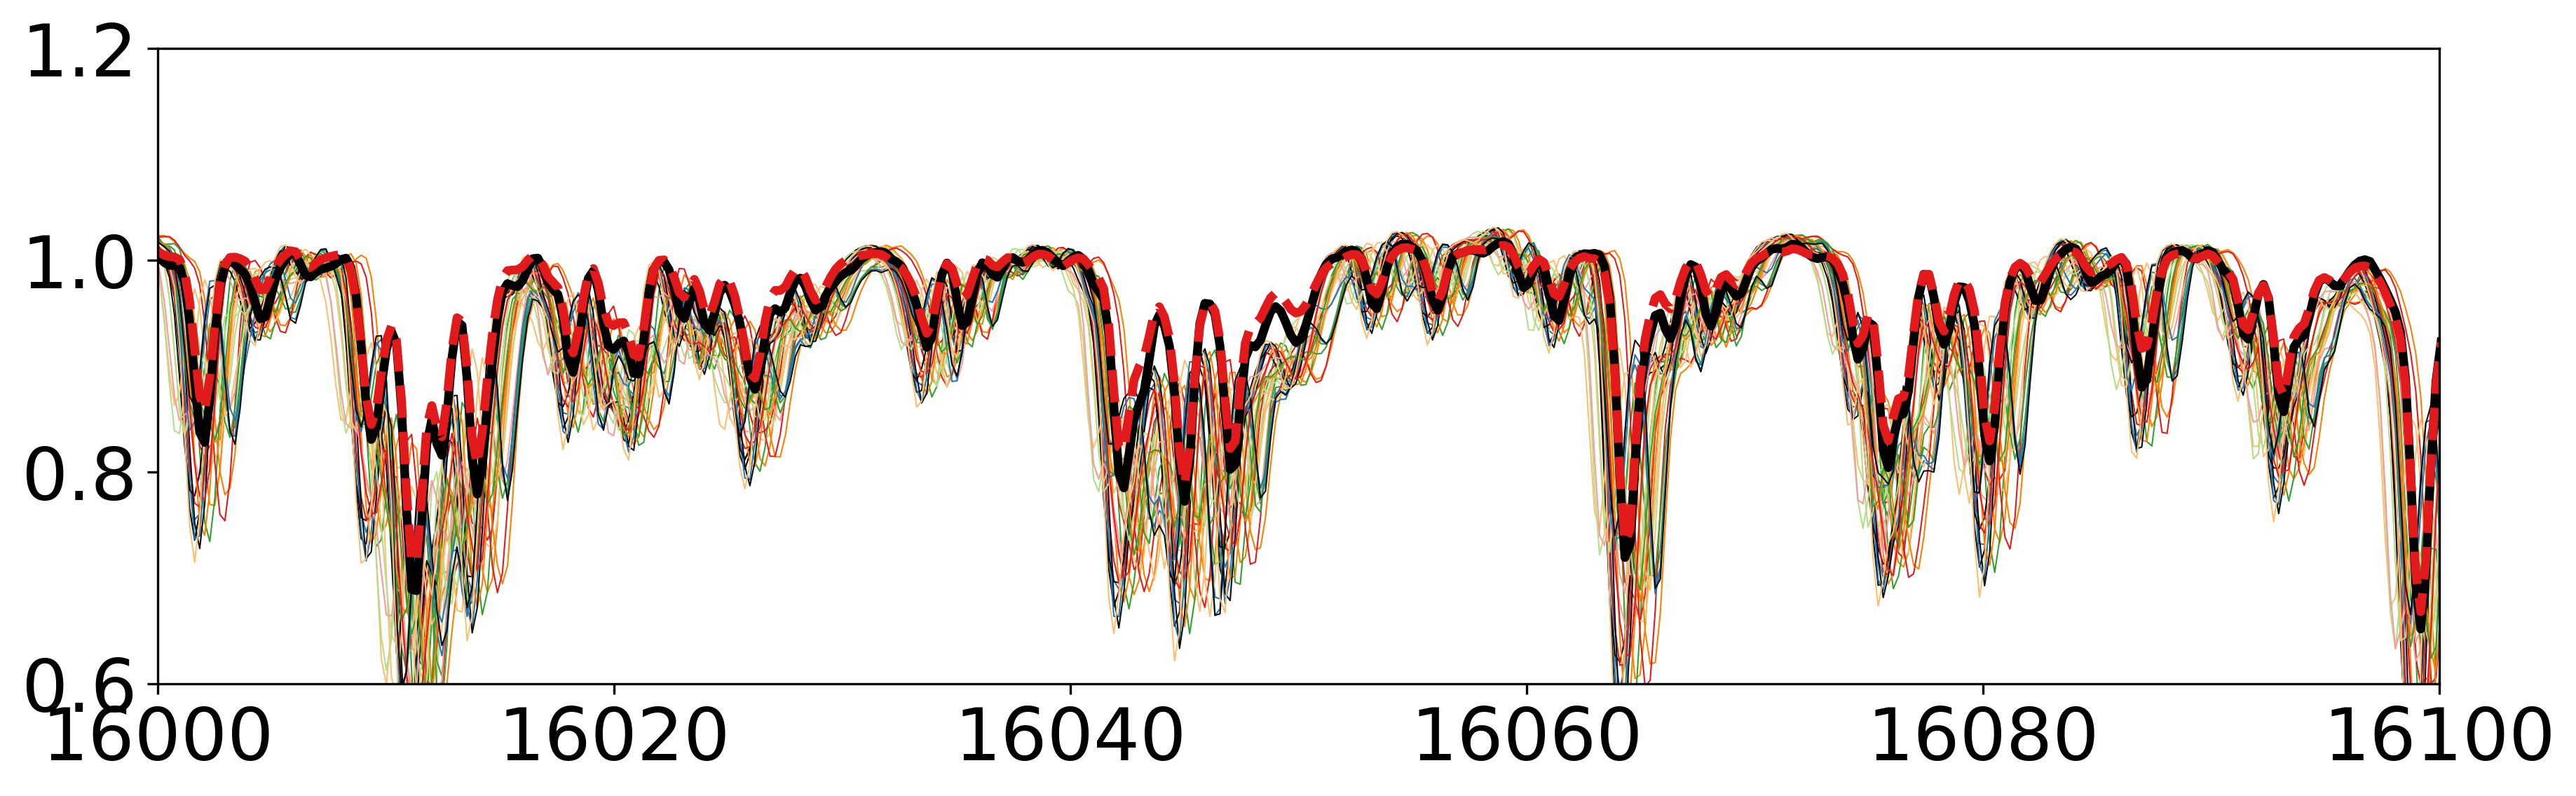

In [16]:
# make RV for the two stars differently
num_obs = 30
RV_array_1 = np.random.uniform(size=num_obs)*50. -25.
RV_array_2 = np.random.uniform(size=num_obs)*50. -25.

#--------------------------------------------------------------------------------------------------
# make rest frame spectrum for spectrum 1
Teff1 = 4750.
logg1 = 2.5
feh = 0.
alphafe = 0.
vmacro = 2.
labels1 = [Teff1, logg1, feh, alphafe, vmacro, 0] 
spec_rest_1 = get_normalized_spectrum_single_star(labels = labels1, 
                    NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux)

# for spectrum 2
Teff1 = 5000.
logg1 = 3.0
feh = 0.
alphafe = 0.
vmacro = 2.
labels1 = [Teff1, logg1, feh, alphafe, vmacro, 0] 
spec_rest_2 = get_normalized_spectrum_single_star(labels = labels1, 
                    NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux)

#--------------------------------------------------------------------------------------------------
# radial velocity shift
c = 3e5
spec_shifted_1 = []
for i in range(RV_array_1.size):
    doppler_factor = np.sqrt((1 - RV_array_1[i]/c)/(1 + RV_array_1[i]/c))  
    new_wavelength = wavelength*doppler_factor
    ind = np.searchsorted(wavelength[:-1], new_wavelength) - 1
    slopes = (spec_rest_1[1:] - spec_rest_1[:-1])/(wavelength[1:]-wavelength[:-1])
    spec_shifted_1.append(spec_rest_1[ind] + slopes[ind]*(new_wavelength - wavelength[ind])) 
spec_shifted_1 = np.array(spec_shifted_1)

spec_shifted_2 = []
for i in range(RV_array_2.size):
    doppler_factor = np.sqrt((1 - RV_array_2[i]/c)/(1 + RV_array_2[i]/c))  
    new_wavelength = wavelength*doppler_factor
    ind = np.searchsorted(wavelength[:-1], new_wavelength) - 1
    slopes = (spec_rest_2[1:] - spec_rest_2[:-1])/(wavelength[1:]-wavelength[:-1])
    spec_shifted_2.append(spec_rest_2[ind] + slopes[ind]*(new_wavelength - wavelength[ind])) 
spec_shifted_2 = np.array(spec_shifted_2)

# combine two normalized flux (ignoring flux ratio) 
# to mock up observations
spec_shifted = spec_shifted_1*spec_shifted_2


#==================================================================================================
# plot the spectrum
lambda_min, lambda_max = 16000, 16100#  wavelength range for plotting 

plt.figure(figsize=(14, 4))
plt.plot(wavelength, spec_shifted.T, lw=0.5)
plt.xlim(lambda_min, lambda_max)
plt.plot(wavelength, spec_rest_1, color="black", lw=3) ## rest frame spectrum 1
plt.plot(wavelength, spec_rest_2, color=cb2[3], ls="--", lw=3) ## rest frame spectrum 2
plt.ylim(0.6, 1.2)


#==================================================================================================
# save array
# cull the few last few pixels because interpolation there tend to extrapolate to weird values
np.savez("fitting_spectra.npz",\
         spec_shifted = spec_shifted[:,10:-10],\
         spec_shifted_1 = spec_shifted_1[:,10:-10],\
         spec_shifted_2 = spec_shifted_2[:,10:-10],\
         RV_array_1 = RV_array_1,\
         RV_array_2 = RV_array_2,\
         spec_rest_1 = spec_rest_1[10:-10],\
         spec_rest_2 = spec_rest_2[10:-10],\
         wavelength = wavelength[10:-10])


## After running with wobble.py

> Plot spectrum prediction. (note, the results could permute the two stars)

In [26]:
# restore training set
temp = np.load("fitting_spectra.npz")
spec_shifted = temp["spec_shifted"]
RV_array_1 = temp["RV_array_1"]
RV_array_2 = temp["RV_array_2"]

# restore results
temp = np.load("../results.npz")
spec_shifted_recovered = temp["spec_shifted_recovered"]
rv_recovered_1 = temp["rv_recovered_1"]
rv_recovered_2 = temp["rv_recovered_2"]

(0, 200)

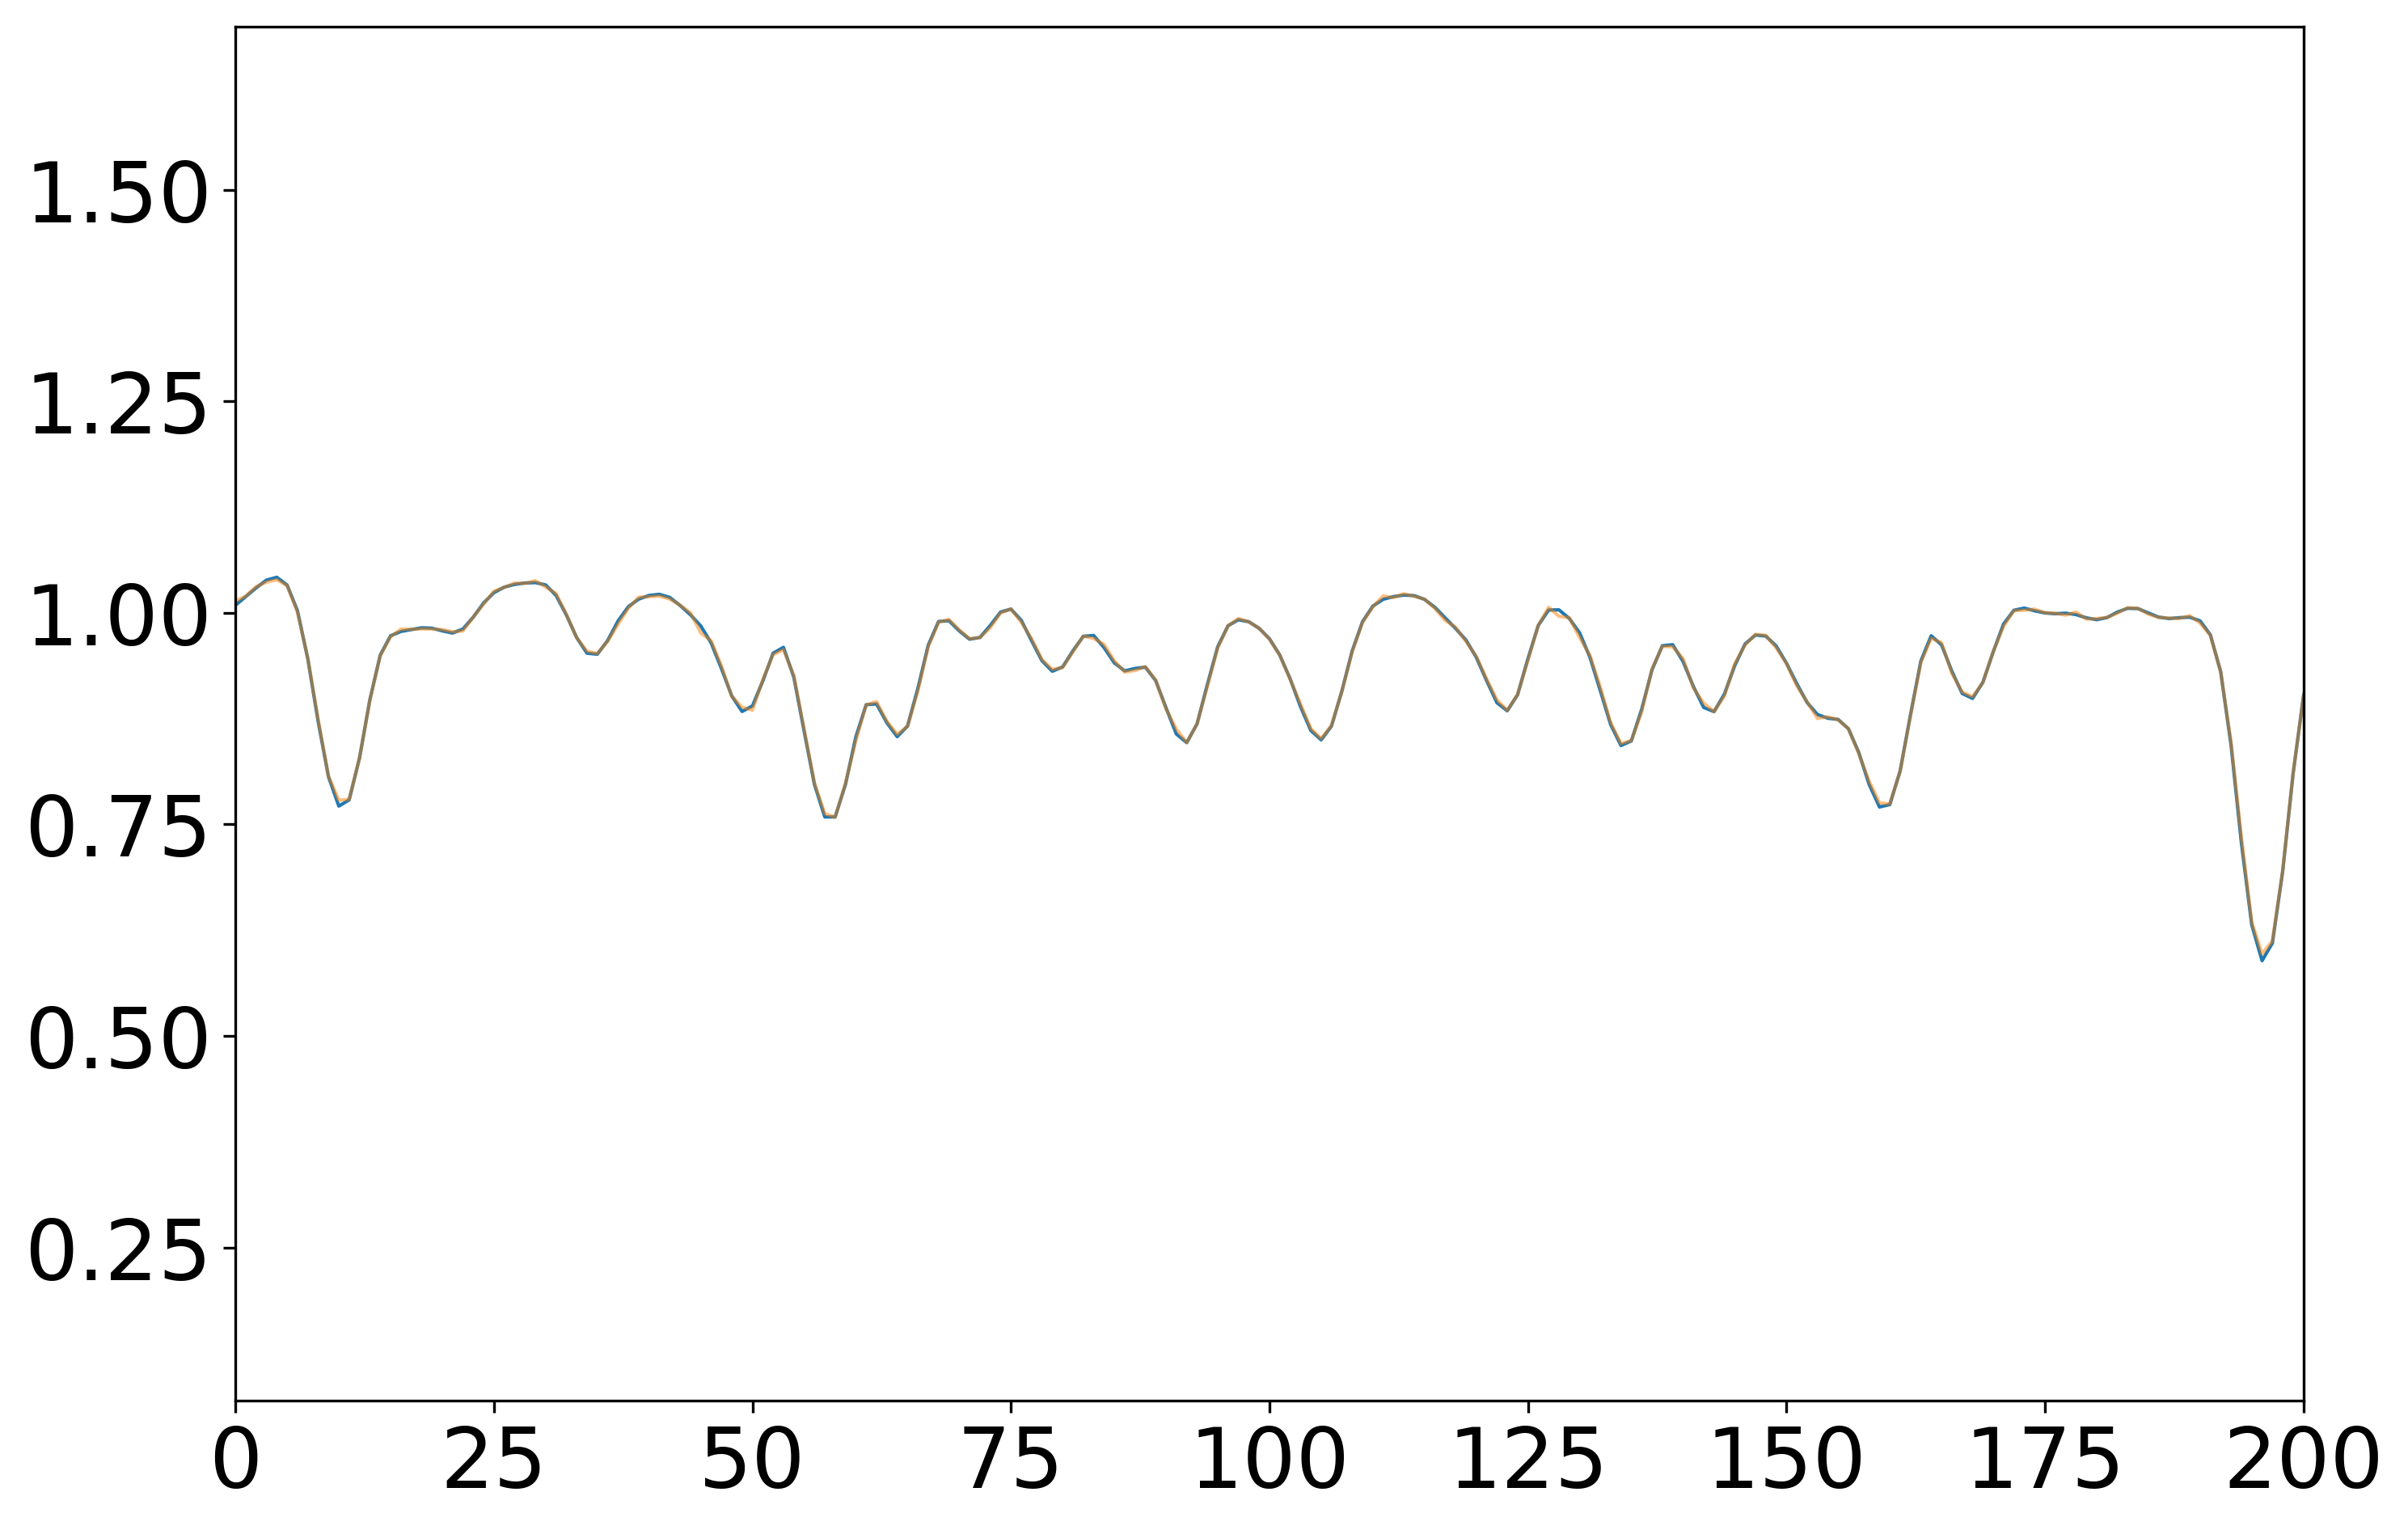

In [27]:
plt.plot(spec_shifted[0,:])
plt.plot(spec_shifted_recovered[0,:], alpha=0.5)
plt.xlim([0,200])

> RV prediction 

Note that since we do not enforce an RV zero point. The RV could have a zero point shift, and so is the corresponding predicted rest frame spectrum. One can imagine to fix this via, for example, Kepler laws of a binary.

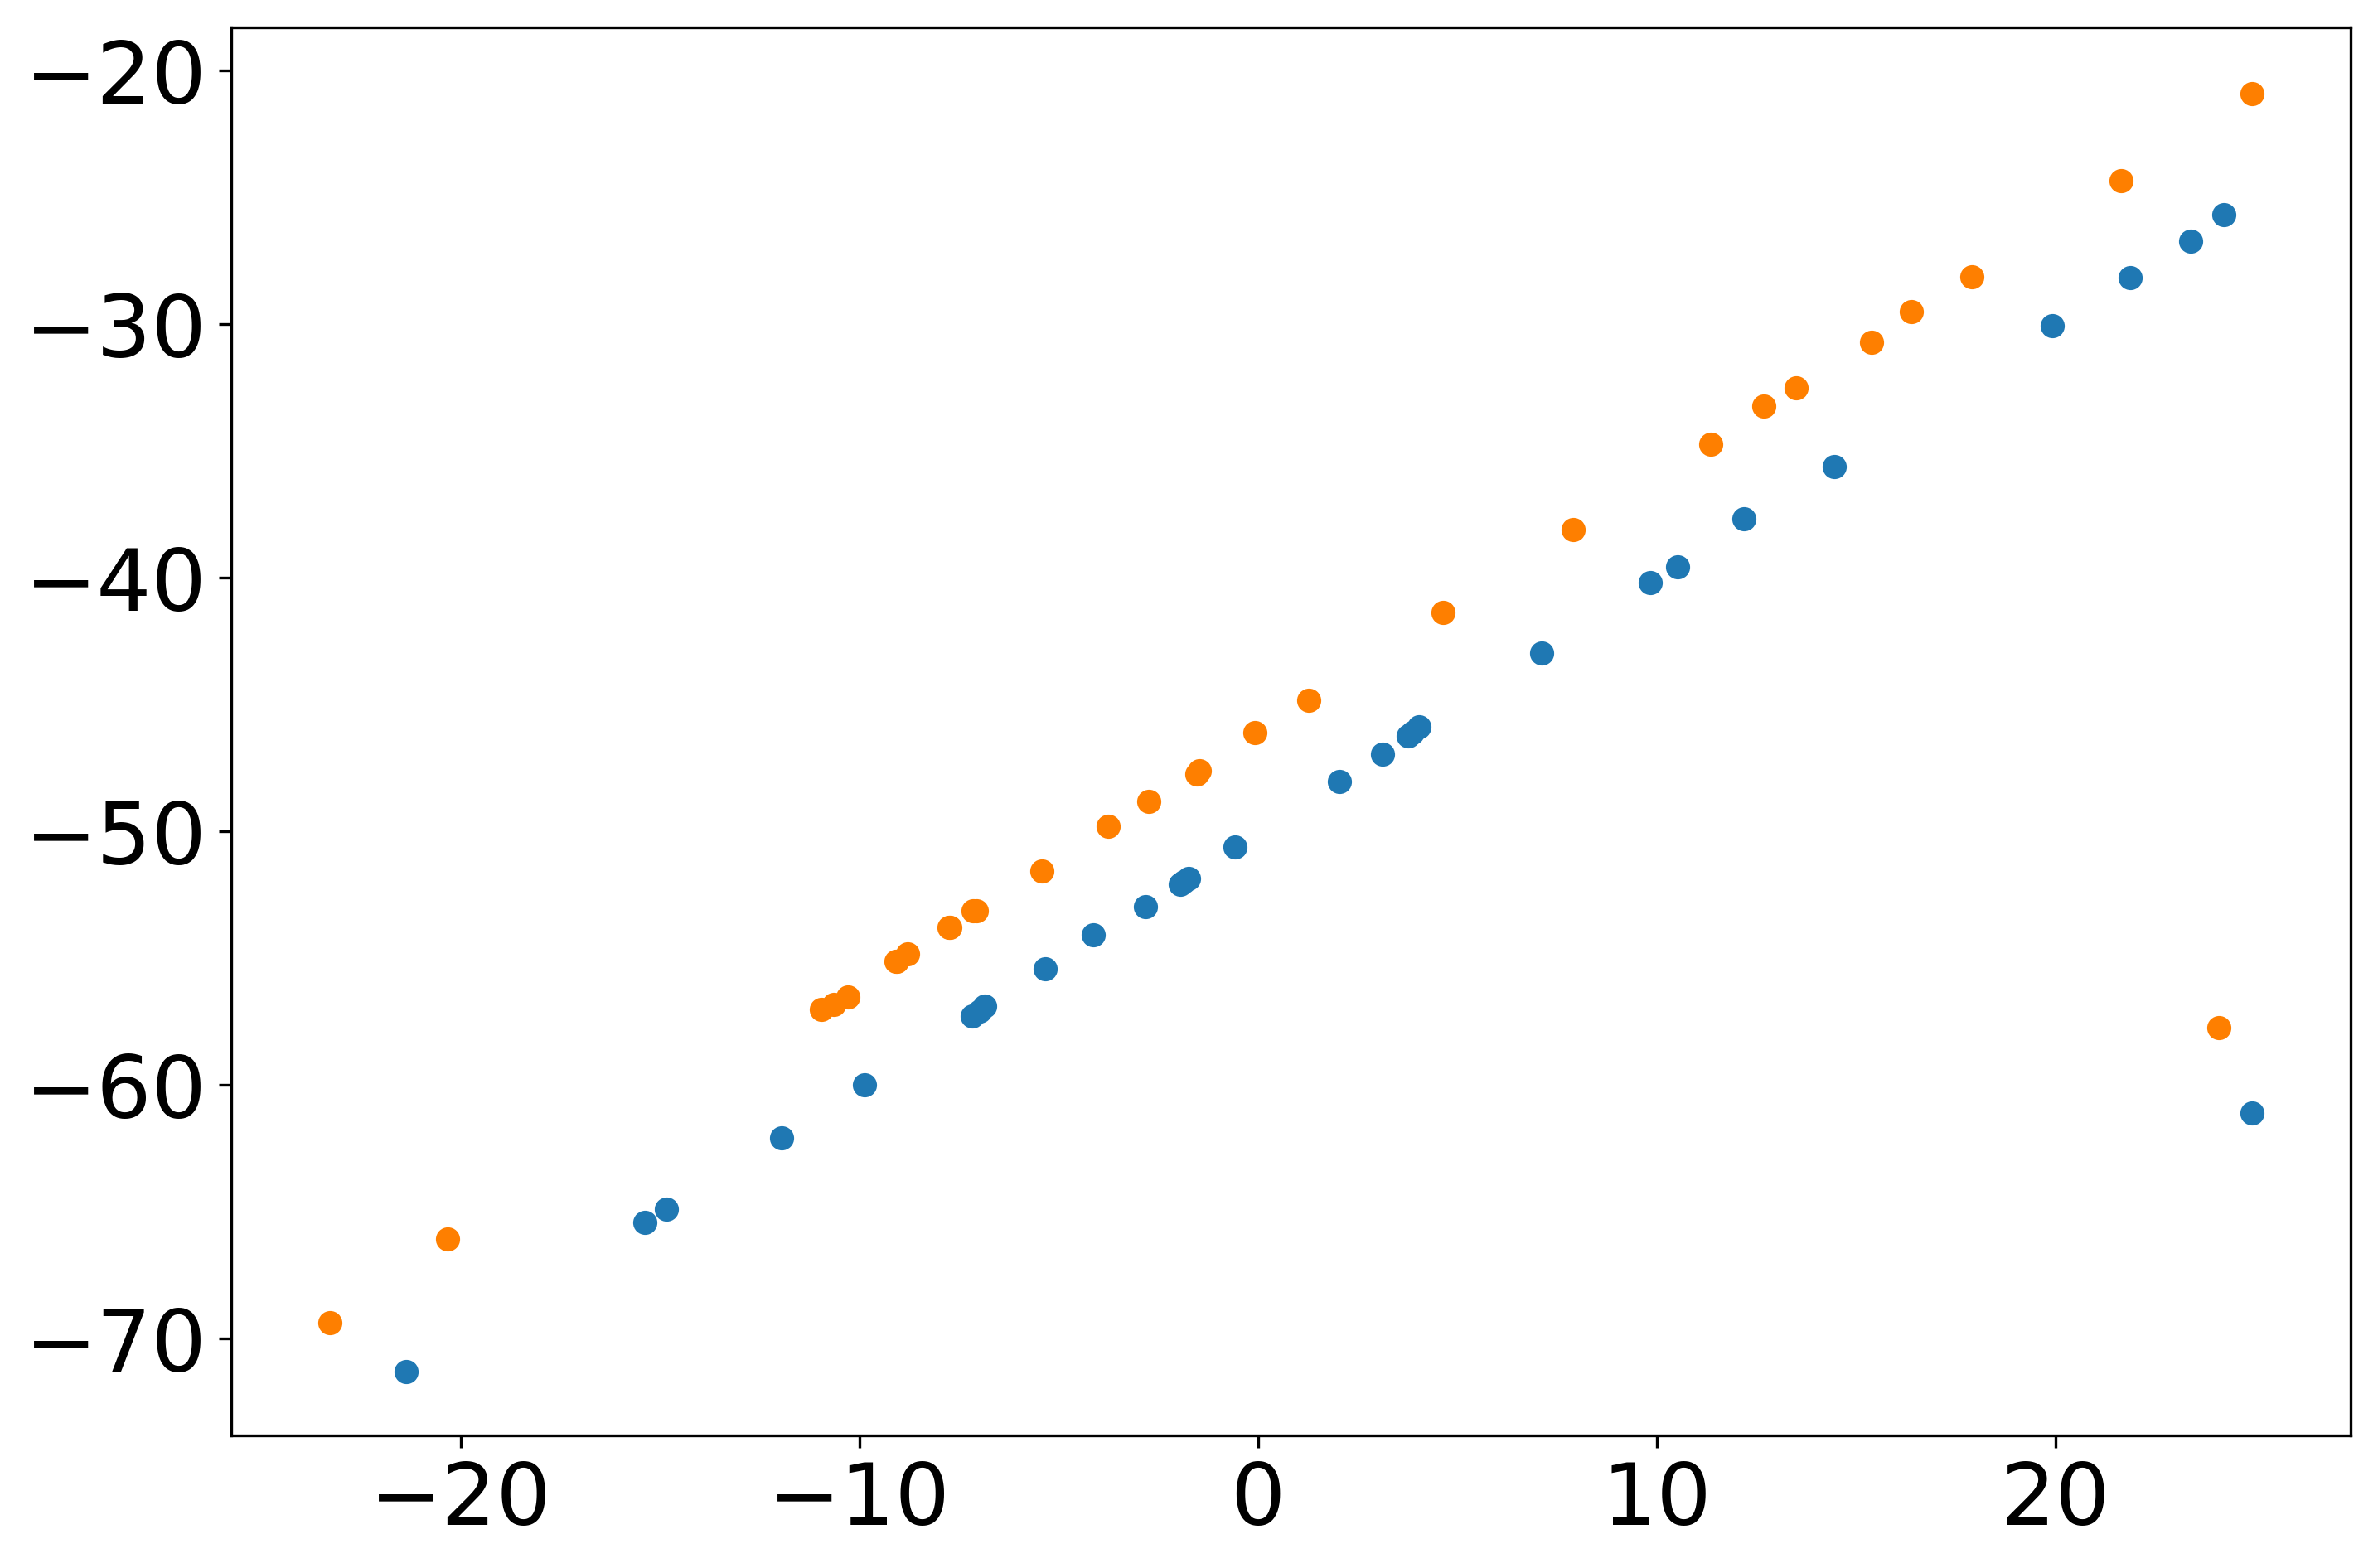

In [29]:
plt.scatter(RV_array_1,rv_recovered_1)
plt.scatter(RV_array_2,rv_recovered_2)